In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

(ml-selection)=
# Model selection

Machine learning practitioners often emphasize the importance of having very
large training datasets. It's all well and good to say that if we want to make
good predictions, we should collect an enormous amount of data; the trouble is
that sometimes that's not feasible. For example, if we're neuroimaging
researchers acquiring structural brain scans from people with an autism
diagnosis, we can't magically make tens of thousands of scans appear out of thin
air. We may only be able to pool together one or two thousand data points, even
with a monumental multi-site effort like the ABIDE initiative.

If we can't get a lot more data, are there other steps we can take to improve
our predictions? We've already seen how cross-validation methods can indirectly
help us make better predictions by minimizing overfitting and obtaining better
estimates of our models' true generalization abilities. In this section, we'll
explore another general strategy for improving model performance: selecting
better models.

## Bias and variance

We've talked about the tradeoff between overfitting and underfitting, and the
related tradeoff between flexibility and stability in estimation. Now we'll
introduce a third intimately-related pair of concepts: bias and variance.
Understanding the difference between bias and variance, and why we can often
trade one for the other, is central to developing good intuitions about when and
how to select good estimators.

It's probably easiest to understand the concepts of bias and variance through
visual illustration. Here's a classic representation:

![](./figures/bias_variance_dartboard.png)

```{eval-rst}
.. index::
   single: Bias variance tradeoff
```

Comparing the top and bottom rows gives us a sense of what we mean by
*variance*: it's the degree of scatter of our observations around their central
tendency. In the context of statistical estimators, we say that an estimator has
high variance if the parameter values it produces tend to vary widely over the
space of datasets to which it could be applied. Conversely, a low-variance estimator
tends to produce similar parameter estimates when applied to different datasets.

Bias, by contrast, refers to a statistical estimator's tendency to produce
parameter estimates that cluster in a specific part of the parameter space. A
high-bias estimator produces parameter estimates that are systematically shifted
away from the correct estimate—even as the size of the training dataset grows
asymptotically. A low-bias estimator, conversely, will converge on the true
parameter estimate as the sample size increases.

### The bias-variance tradeoff

One interesting property of bias and variance is that they tend to trade off.
That is, one can often decrease the variance of an estimator by deliberately
increasing its bias or vice versa. To see this intuitively, imagine the extreme
case of an estimator that always generates an identical prediction for all
observations. Such an estimator would have low variance (actually, *no*
variance) and extremely high bias. Conversely, an estimator that produces
extremely variable estimates must be one capable of freely exploring various
parts of parameter space—and hence, shows a weaker preference for, or bias
towards, certain parts of the space.

This idea has a deep connection to the overfitting/underfitting and
flexibility/stability distinctions we drew earlier. All three distinctions
ultimately reflect the same core idea. A *high-variance* (low-bias) estimator is
a *flexible* one that can identify a wide variety of patterns in the data; this
also makes it more likely to *overfit*. Conversely, a high-bias (low-variance)
estimator is a *stable* one that tends to produce similar parameter estimates no
matter what data it's presented with; such an estimator will frequently
*underfit* because it lacks the flexibility needed to capture complex patterns
in the data.

Neuroimaging researchers coming from a traditional scientific background often
think of bias as a dirty word -— i.e., as something to be minimized at all
costs. From a machine learning standpoint, however, there's nothing
intrinsically bad about bias. The bias of a particular model is nothing more
than its systematic tendency to produce parameter estimates that cluster within
a particular part of the space. Not only is this not a bad thing, but it's often
essential to producing good predictions. The bias of a given estimator -- its
tendency to give certain kinds of solutions  -- is often referred to as its
*inductive bias*. The key question is then: *to what degree does the inductive
bias of a given estimator match the processes that give rise to our data?*


```{eval-rst}
.. index::
   single: Inductive bias
```

In cases where there's a match between an estimator and the data it's applied
to, a biased estimator will tend to perform better than a less biased one.
Conversely, if an estimator has the *wrong* bias, it will tend to perform more
poorly than an estimator with less bias.

This is a fairly abstract idea, so let's make it concrete. Suppose you park your
car at the airport parking lot when you head off for a weekend vacation.
Consider two possible strategies you could use to find your car on your return.
First, you might rely on your memory of where you left the car; perhaps you
think you left it somewhere near that light pole over there in the `B` area of
the lot. Second, you could just randomly roam around the parking lot looking for
a car that looks like yours.

Which of these is the better car-finding strategy? Well, it depends! If you have
a good memory, the high-bias strategy -— only searching within a particular part of
the lot —- will lead you to your car more quickly than a random walk around the
entire lot. But if your memory is poor, the biased strategy is likely to be
counterproductive, because your car won't be where you remember leaving it, no
matter how much time you spend walking around that specific area. In the latter
case, you would have been better off randomly walking around until you found
your car.

## Regularization

```{eval-rst}
.. index::
   single: Regularization
```

Our car parking example is a bit contrived, but it illustrates a core principle at the heart of good model selection: *if we have useful prior knowledge about the domain, we should pick an estimator that builds that knowledge into its assumptions*. For example, if we have a set of 1,000 potential features we could use in our model, but have good reason to believe that only a small fraction of those features make a meaningful contribution to the outcome variable, it seems like a good idea to use an estimator that can somehow *select* a subset of features. Using an estimator that acts as if all of our features are potentially important (as linear regression does) is likely to lead to overfitting.

The principle of introducing background knowledge into our model to improve
predictions and prevent overfitting is known in machine learning and statistics
as *regularization*. When we say we're using a regularized estimator, what we're
typically saying is that we've taken an existing estimator (e.g., an OLS
estimator) and constrained its behavior with additional information, so that
it's *biased* towards certain parts of the parameter space.

(penalized_regression)=
### Penalized regression

To researchers who learned statistics in biomedical or social science training
programs, it may be tempting to think of least-squares estimation as a kind of
automatic default, with all other procedures requiring some special
justification to use. But there's nothing special about OLS. Well, it's
*kind of* special in that it always minimizes the squared error in our training
sample. But as we've already seen, we usually care about minimizing test error,
not training error (plus, sometimes we don't want to quantify error in terms of
a least-squares criterion). So if we can get our hands on an estimator that's
biased relative to OLS, but tends to reduce error in the *test* dataset, we
probably still want to use it -— even if it doesn't reduce error in the *training*
data quite as well as OLS.

It turns out that there are many such estimators. One of the most widely used
class of regularized estimators for regression problems is *penalized regression*. These methods generally start with garden variety OLS and then add
a little twist in the form of a *penalty* parameter.

Consider the cost function we seek to minimize in OLS:

$Cost = RSS = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2$

Here, $RSS$ is the residual sum of squares, $N$ is the number of samples, and
$P$ is the number of features. Our goal is to obtain the set of $\beta$
coefficients that minimize the $RSS$.

Now consider a slight variation:

$Cost = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2 + \alpha\sum^P_j|\beta_j|$

The only difference here is that, in addition to the $RSS$, our cost function
includes a second term, $\alpha\sum^P_j|\beta_j|$ -— the sum of absolute values
of the $\beta$ coefficients, weighted by the *penalty* parameter, $\alpha$. The
addition of the penalty parameter is the reason we refer to this variation on
linear regression as penalized regression. The addition of the penalty may seem
like a small change, but it has major consequences, which we'll explore shortly.

The above form of penalized regression is known as *lasso regression*, and it's
very widely used. There's also another very common form of penalized regression
known as *ridge regression*. It looks a lot like lasso regression, except
instead of computing the penalty as the sum of absolute coefficients, we take
the sum of their squares:

$Cost = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2 + \alpha\sum^P_j\beta_j^2$

The difference between lasso and ridge regression may seem even smaller, but it
again has important implications. Let's explore the behavior of each of these
methods.

```{eval-rst}
.. index::
   single: Regularization
```

```{eval-rst}
.. index::
   single: Penalized regression
```


```{eval-rst}
.. index::
   single: Ridge regression
```

```{eval-rst}
.. index::
   single: Lasso
```

#### Lasso regression

```{eval-rst}
.. index::
   single: Lasso regression
```

Let's take the lasso first. Let's think about what the addition of the penalty
term to the standard RSS criterion does, conceptually. By making the overall
cost depend on a (weighted) sum of absolute coefficients, we're saying that
there's a certain cost to having large coefficients in our model. If the net
negative contribution of a given feature to the RSS is smaller than its net
positive contribution to the penalty, then it will be beneficial to "shrink"
that feature's coefficient to the point where the two terms perfectly cancel
each other out. Thus, penalized regression *biases* the estimated regression
coefficients by shrinking at least some of them.

For reasons outside the scope of our discussion here, the lasso doesn't just
shrink coefficients; it shrinks them to zero. That is, as we increase the
penalty, more features drop out of our model, leaving us with a simpler
prediction equation involving fewer features. For this reason, the lasso is
often described as implicitly including a *feature selection* step.

```{eval-rst}
.. index::
   single: Feature selection
```

To see how this works in practice, let's return to our ABIDE-II data and
visualize what happens to our regression coefficients estimated with lasso
regression as we increase the penalty parameter. Here, we'll plot the
*coefficient paths*: how each coefficient changes as $\alpha$ changes
(judiciously picking a reasonable range of $\alpha$ values). We've implemented
a `plot_coef_path` function that does this. Note also that we standardize our
features to mean-zero and unit-variance because lasso and ridge are sensitive
to scale.

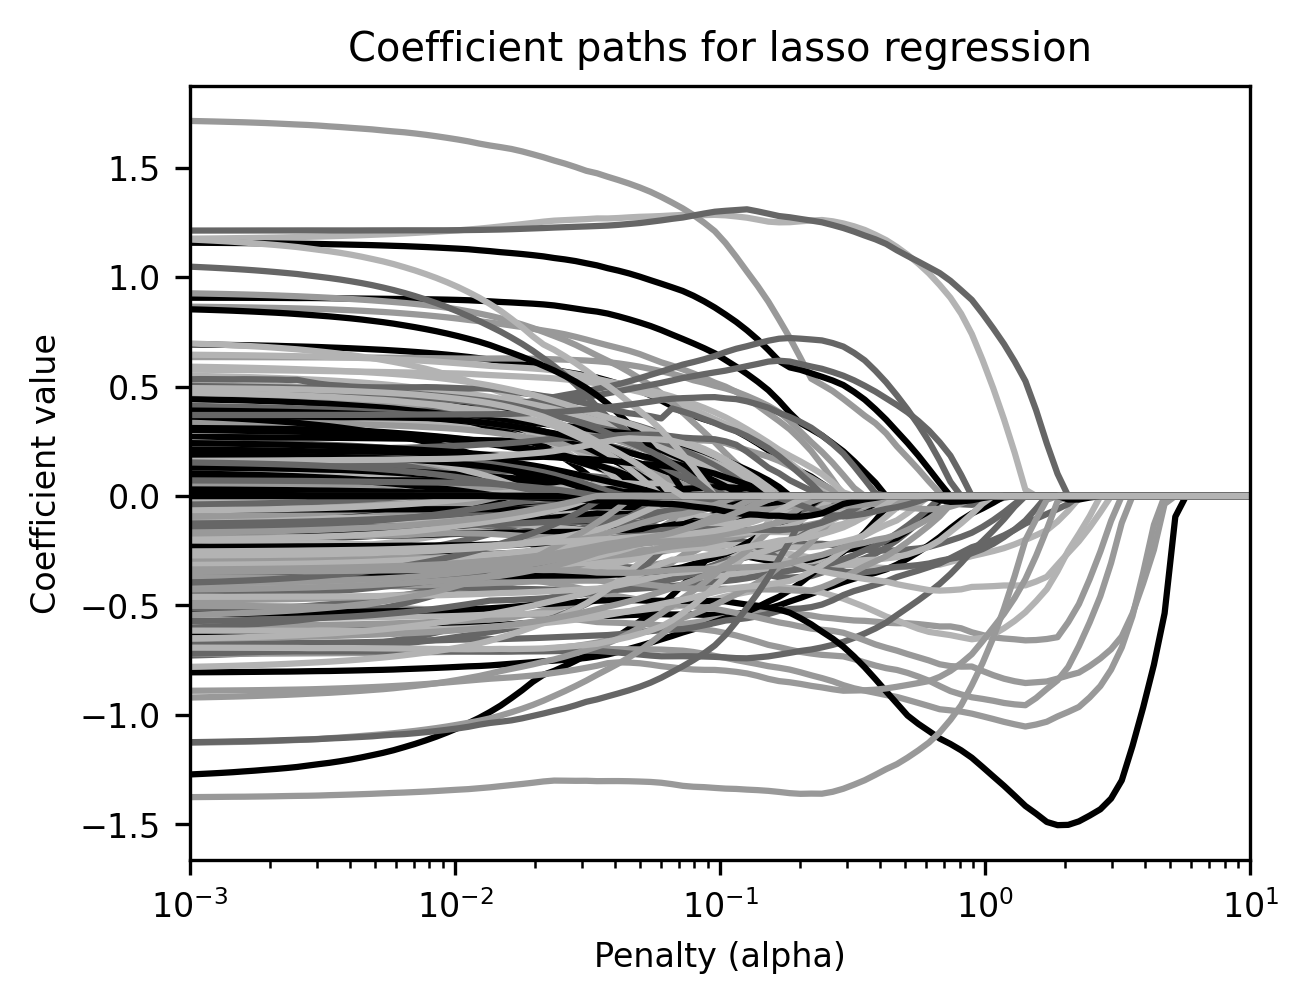

In [2]:
from ndslib.viz import plot_coef_path
from ndslib.data import load_data
abide_data = load_data("abide2")
features = abide_data.filter(like='fs')
phenotypes = abide_data.iloc[:, :6]

from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

number_of_features = 200

X = scale(features.sample(number_of_features, axis=1, random_state=99))
y = phenotypes['age']

import numpy as np
alpha = np.logspace(-3, 1, 100)
ax = plot_coef_path(Lasso, X, y, alpha, max_iter=2000)
ax.set_title("Coefficient paths for lasso regression")
ax.set_xlim(1e-3, 10);

In the figure produced by the `plot_coef_path` helper function, each line
represents a different feature. We're using 200 randomly selected features (from
the full set of 1,440) as predictors, so there are 200 lines. The x-axis
displays the penalty parameter used for lasso estimation; the y-axis displays
the resulting value of the coefficients. Notice how, at a certain point (around
`alpha = 0.01`), coefficients start to disappear. They're not just small;
they're *gone* (i.e., they've been "shrunk" to 0). This built-in feature
selection is a very useful property of the lasso. It allows us to achieve an
arbitrarily sparse solution simply by increasing the penalty.

(ml-selection_ex1)=
#### Exercises

1. Change the `number_of_features` variable to be much larger (e.g., 400) or
   much smaller (e.g., 100). How are the coefficient paths affected by this
   change? Why do you think these changes happen?

2. What happens if you use the site-residualized ages instead of the age variable?

Of course, as you know by now, *there's no free lunch in machine learning*.
There must be some price we pay for producing more interpretable solutions with
fewer coefficients, right? There is. We'll look at it in a moment; but first,
let's talk about ridge regression.

#### Ridge regression

```{eval-rst}
.. index::
   single: Ridge regression
```

Ridge regression, as noted above, is mathematically very similar to lasso regression. But it behaves very differently. Whereas the lasso produces sparse solutions, ridge regression, like OLS, always produces dense ones. Ridge *does* still shrink the coefficients (i.e., their absolute values get smaller as the penalty increases). It also pushes them towards a normal distribution. The latter property is the reason a well-tuned ridge regression model usually outperforms OLS: you can think of ridge regularization as basically a way of saying *it may **look** like a few of the OLS coefficients are way bigger than others, but that's probably a sign we're fitting noise. In the real world, outcomes usually reflect the contributions of a lot of different factors. So let's squash all of the extreme values towards zero a bit so that all of our coefficients are relatively small and bunched together.*

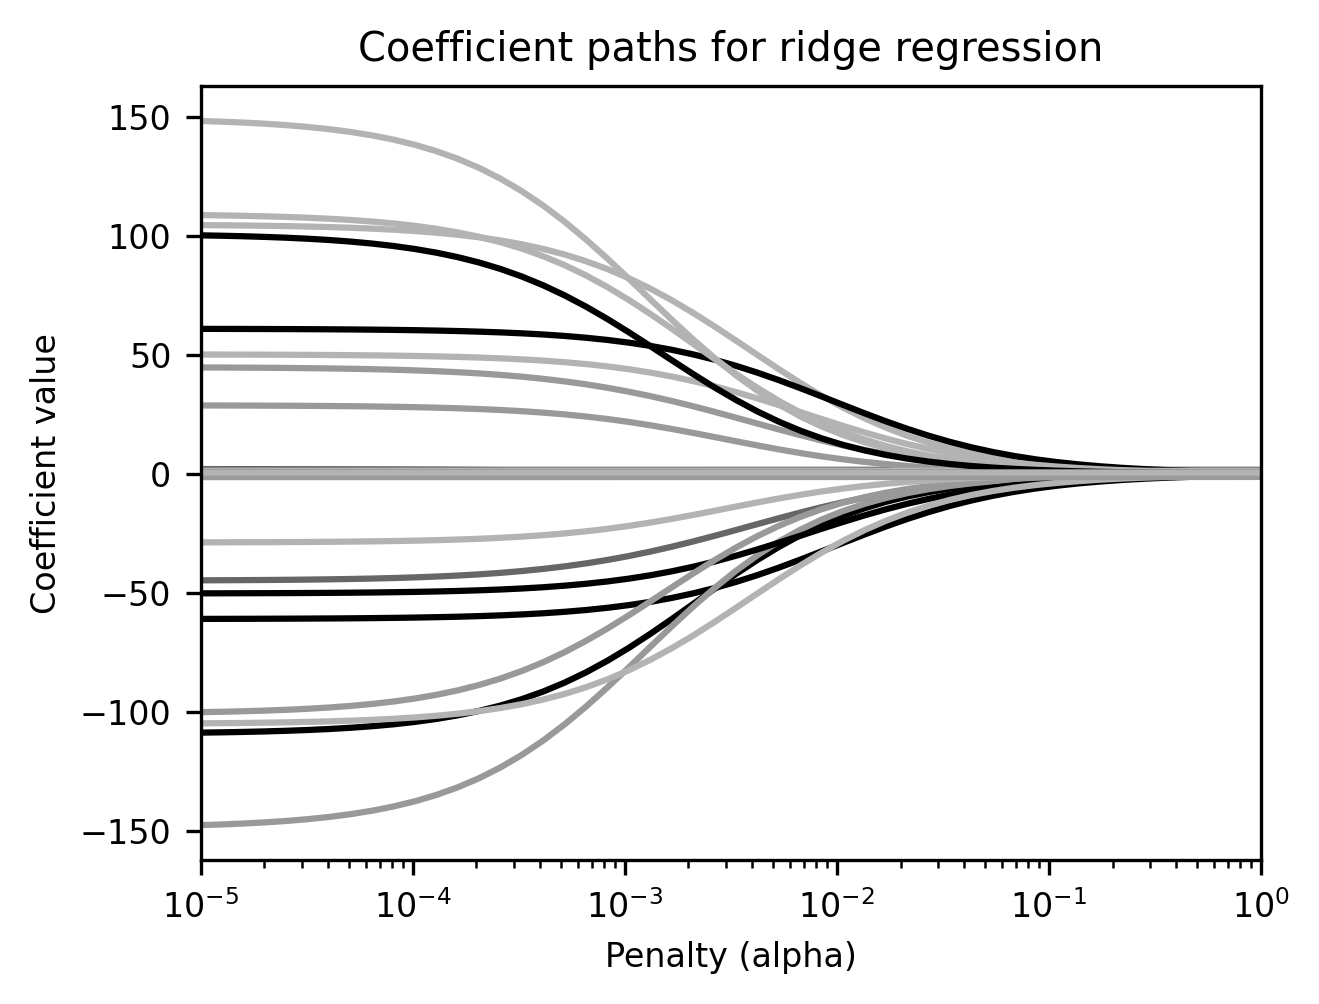

In [3]:
from sklearn.linear_model import Ridge

# Coefficient paths for ridge regression, predicting age from 30 features
alpha = np.logspace(-5, 5, 100)
ax = plot_coef_path(Ridge, X, y, alpha)

ax.set_title("Coefficient paths for ridge regression")
ax.set_xlim(1e-5, 1);

It may look to the eye like the coefficients are shrinking all the way to zero
as the penalty increases, but we promise you they aren't. They may get very
small, but unlike lasso regression, ridge coefficients will never shrink to
nothing.

#### Effects of regularization on predictive performance

We've looked at two different flavors of penalized regression, and established
that they behave quite differently. So, which one should we use? Which is the
*better* regularization approach? Well, as with everything else *it depends*. If
the process(es) that generated our data are sparse (or at least, have a good
sparse approximation) -— meaning, a few of our features make very large
contributions, and the rest don't matter much —- then lasso regression will tend to
perform better. If the data-generating process is dense—i.e., lots of factors
make small contributions to the outcomes—then ridge regression will tend to
perform better.

In practice, we rarely know the ground truth when working with empirical data.
So we're forced to rely on a mix of experience, intuition, and validation
analyses.

Let's do some of the latter here. To try to figure out what the optimal lasso
and ridge penalties are for our particular problem, we'll make use of Scikit
Learn's `validation_curve` utility, which allows us to quickly generate training
and testing performance estimates for an estimator as a function of one of its
parameters. As alluded to in {numref}`ml-validation`, the `validation_curve` is
very similar to the `learning_curve` we've seen before, except that instead of
systematically varying the dataset size, we systematically vary one of the
estimator's parameters (in this case, `alpha`). Let's generate a validation
curve for lasso regression, still using 200 random features to predict age.
We'll add OLS regression $R^2$ for comparison and use our `plot_train_test`
helper function to visualize it.

(0.001, 10)

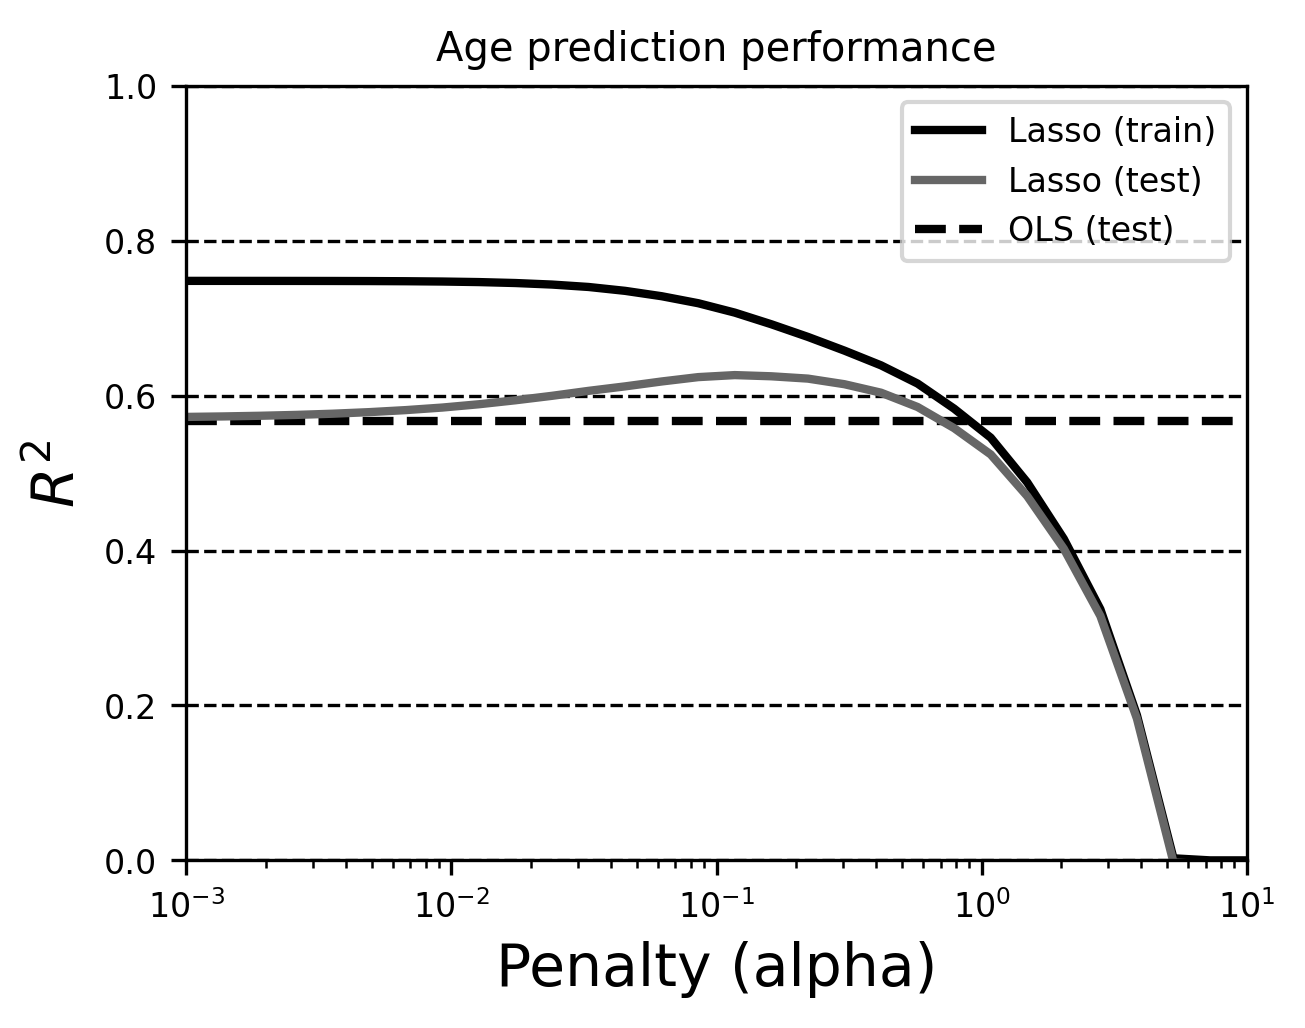

In [4]:
from sklearn.model_selection import validation_curve, cross_val_score
from sklearn.linear_model import LinearRegression
from ndslib.viz import plot_train_test

x_range = np.logspace(-3, 1, 30)
train_scores, test_scores = validation_curve(
   Lasso(max_iter=5000), X, y, param_name='alpha',
   param_range=x_range, cv=5, scoring='r2')

ols_r2 = cross_val_score(
   LinearRegression(), X, y, scoring='r2', cv=5).mean()

ax = plot_train_test(
   x_range, train_scores, test_scores, 'Lasso',
   hlines={'OLS (test)': ols_r2})

ax.set_title("Age prediction performance")
ax.set_xlim(1e-3, 10)

Notice that, in the training dataset, $R^2$ decreases monotonically as alpha
increases. This is necessarily true (Why do you think that is? *Hint*: think of
how $R^2$ is defined, and its relationship to the least-squares component of the
lasso cost function.)

In contrast, the error in the test dataset is lowest within a specific range of
`alpha` values. This optimum will vary across datasets, so you'll almost always
need to tune the alpha parameter (e.g., using a validation curve like the one
above) to get the best performance out of your model. This extra degree of
complexity in the model selection process is one of the reasons you might *not*
want to always opt for a penalized version of OLS, even if you think it can
improve your predictions. If you muck things up and pick the wrong penalty, your
predictions could be way worse than OLS!

While we've only looked at one dataset, these are fairly typical results; in
many application domains, penalized regression models tend to outperform OLS
when using small to moderate-sized samples. When samples get very large relative
to the number of features, the performance difference usually disappears.
Outside of domains with extremely structured and high-dimensional data, this
latter principle tends to be true more globally -— i.e., "more data usually beats
better algorithms."

(ml-selection_ex2)=
#### Exercise

Use a similar approach to compare ridge regression with OLS.

## Beyond linear regression

We've focused our attention here on lasso and ridge regression because they're
regularized versions of the OLS estimator most social scientists are already
familiar with. But just as there's nothing special about OLS, there's also
nothing special about (penalized) regression in general. There are many
different estimators we could use to generate predictions. Each has its own
inductive biases and will perform better on some datasets and worse on others.
The science (or perhaps art) of machine learning lies in understanding the
available estimators, data, and validation methods well enough to know how to
tailor optimal (or at least good) machine learning workflows to the specific
problem at hand. Let's forge ahead with one more widely-used class of algorithms
that differs quite a bit from the regression algorithms you've seen here so far.

### Random forests

```{eval-rst}
.. index::
   single: Decision trees
```

```{eval-rst}
.. index::
   single: Random forests
```

To illustrate how easy it is to try out completely different types of estimators
in Scikit-learn -- and also draw attention to the fact that estimators based on
linear regression represent only a small part of the space--let's repeat some of
our earlier regression analyses using a very different estimator: the
`RandomForestRegressor`. Random forests are essentially collections (or
*ensembles*) of decision trees. A decision tree is a structure for generating
classification (classification trees) or regression (regression trees)
predictions. Here's an example of what a regression tree might look like if used
in our ABIDE-II dataset to try and predict age from structural brain features:

![decision tree example](figures/tree.png)

At each node, we evaluate a particular conditional. For example, the first
question we ask is: is the subject's observed value on the fsCT_218 variable
less than or equal to 2.49, or is it greater? We follow the appropriate branch
to the next node and answer the question we find there. We repeat this process
until we reach a terminal node (or "leaf"), whereupon the tree produces the
predicted value for that observation.

Random forests extend this idea by "bagging" multiple decision trees and
aggregating their outputs. Decision trees are very flexible and have the
propensity to overfit. By averaging over a lot of different trees (each one
generated by, e.g., resampling the data), we hopefully stabilize our predictions
and reduce overfitting. Random forests are popular because they're extremely
powerful, their constituent trees are highly interpretable, and they tend to
perform well when we have a lot of data. The downsides are that being very
flexible, they have a tendency to overfit, and careful tuning may be required to
achieve good performance. They can also be quite slow, as performance tends to
improve with the number of decision trees. In the example below we will reduce
tree complexity and mitigate overfitting by performing an explicit feature
selection step before fitting the model. This is done using the `SelectKBest`
object and an `f_regression` criterion, which selects the $k$ features that have
the strongest correlation with the target (based on an F-test -- hence the
name). Ideally, we'd want to use a larger number of trees, but this would be very
slow, so we stick with a small number (10) for demonstration purposes (but
please do experiment with changing these numbers!)

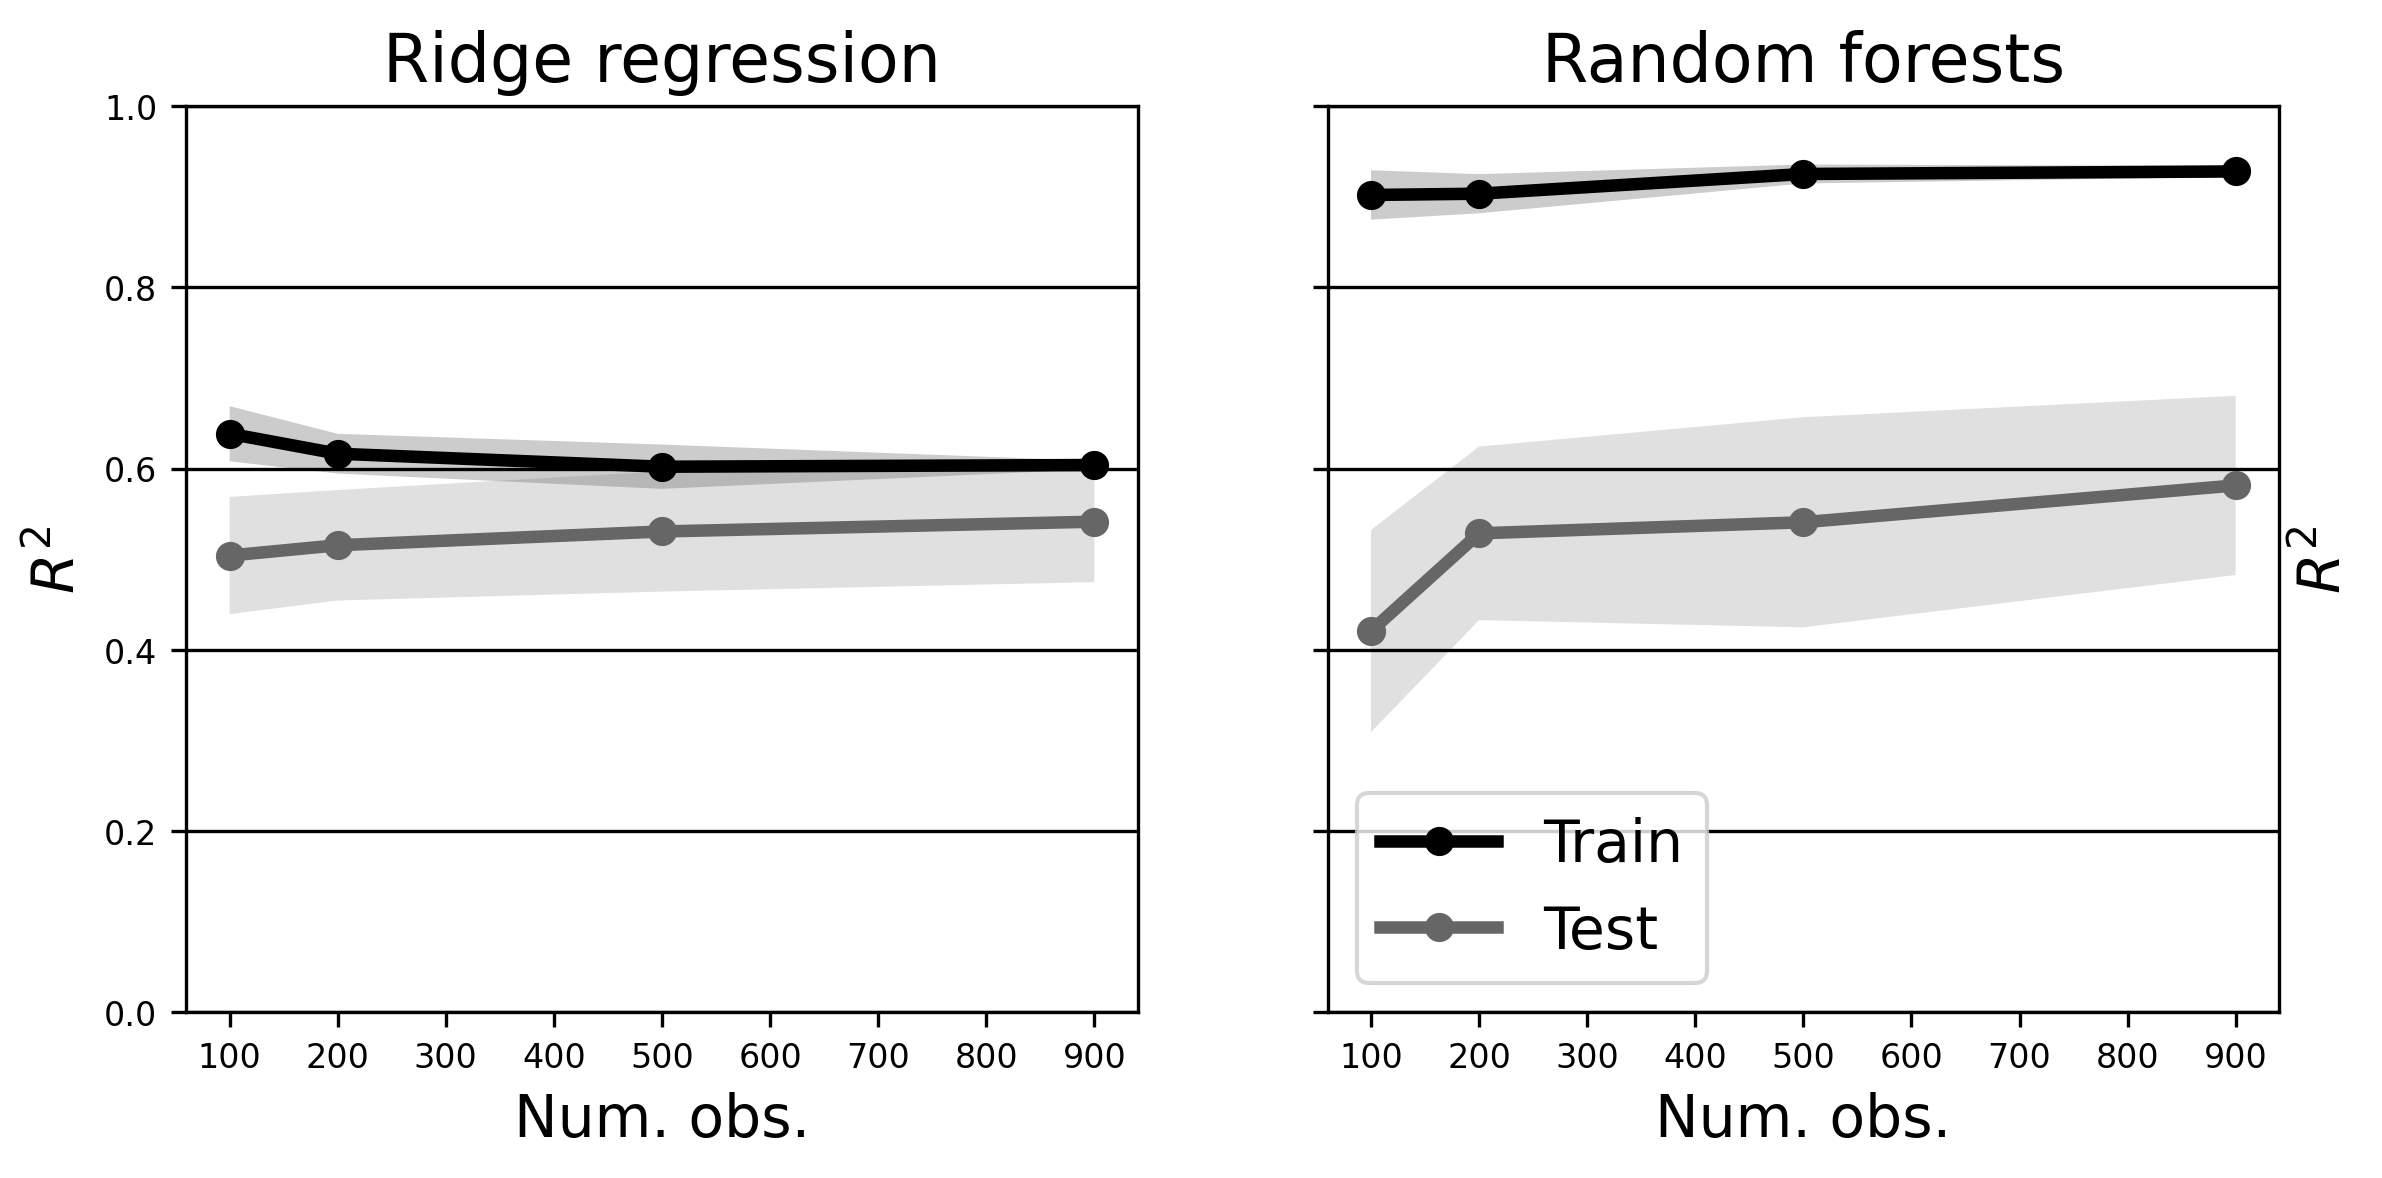

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

from ndslib.viz import plot_learning_curves


number_of_features = 50
alpha = 10
number_of_trees_in_forest = 10

selector = SelectKBest(f_regression, k=number_of_features)
X = selector.fit_transform(features, y)

estimators = [Ridge(alpha), RandomForestRegressor(number_of_trees_in_forest)]
labels = ["Ridge regression", "Random forests"]

plot_learning_curves(estimators, [X, X], y, [100, 200, 500, 900], labels)

In this case, the random forest estimator slightly outperforms ridge regression,
particularly as the sample size gets larger. But it's worth reiterating our
earlier point: this isn't some kind of law, or even a particularly good
heuristic; if you play with various parameters above (e.g.,
`number_of_features`, `alpha`, etc.), you can easily find regimes under which
ridge regression performs better.

#### Interpreting random forests

Unlike regression-based methods, decision trees (and hence random forests) don't
have linear coefficients. Instead, we can obtain *feature importances*, which
tell us how important each feature is to the overall prediction (more important
features are better at reducing uncertainty, and occur closer to the root of the
tree). Let's randomly sample 30 features and work with those. After fitting, we
will print out the names of the 10 most important features.

In [6]:
rf = RandomForestRegressor(100)

X = features.sample(30, axis=1)
rf.fit(X, y)

import pandas as pd
print(pd.Series(
   rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10))

fsCT_R_V2_ROI       0.272581
fsCT_R_MBelt_ROI    0.240108
fsCT_L_VMV2_ROI     0.044474
fsVol_L_PF_ROI      0.040136
fsCT_L_IP2_ROI      0.034641
fsVol_L_EC_ROI      0.028645
fsCT_L_a24pr_ROI    0.025200
fsVol_L_PeEc_ROI    0.023855
fsVol_R_2_ROI       0.022004
fsCT_R_LIPd_ROI     0.019635
dtype: float64


Be aware that there are some important subtleties related to the
interpretation of feature importances, not least of which is that, as with any
model, feature importances are configural: a feature may seem important when
modeled alongside one set of other features, but unimportant when included with
a different set of features.

#### Visualizing trees

We can also plot the individual decision trees. Note that different trees can
often exhibit very different structures despite performing equally well
predictively—an observation that should lead us to exercise caution when
interpreting decision trees, even if they *seem* straightforward. In this
particular case, as we saw above, a handful of features dominate the list of
feature importances, so we might expect at least the first few nodes to look
relatively similar. Let's take a look at the first two trees in the forest.

In [7]:
from ndslib.viz import plot_graphviz_tree
plot_graphviz_tree(rf.estimators_[0], X.columns)

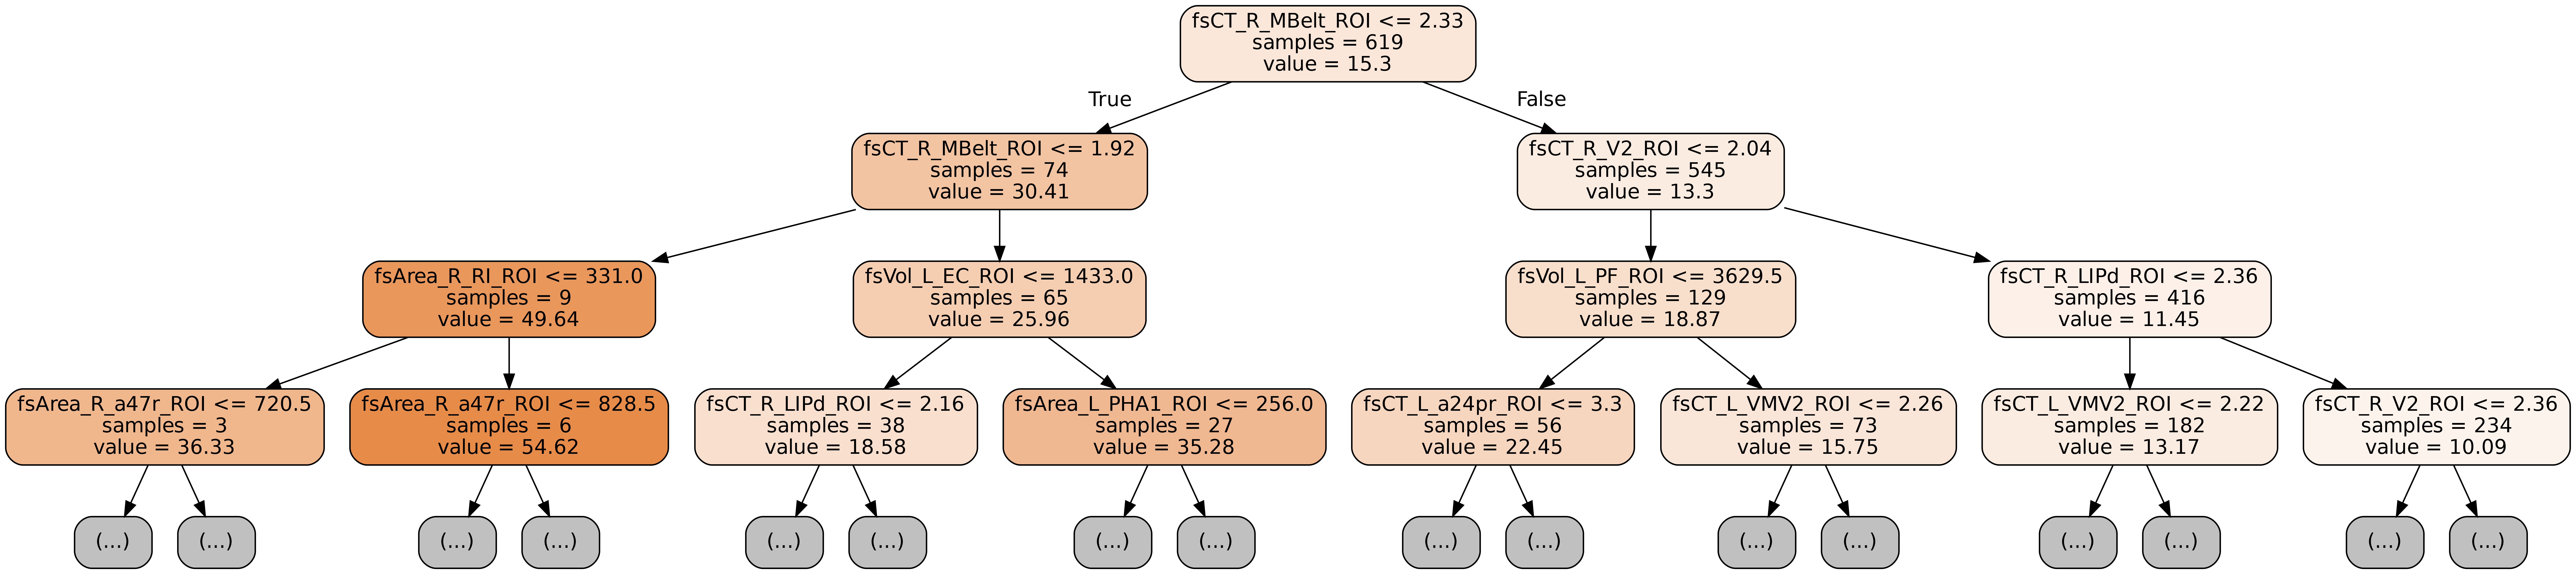

In [8]:
plot_graphviz_tree(rf.estimators_[2], X.columns)

### Additional resources

To learn more about the properties of the lasso and ridge algorithms, we'd recommend reading an excellent tutorial by Ryan Tibshirani that Larry Wasserman amended and posted on [his website](https://www.stat.cmu.edu/~larry/=sml/sparsity.pdf). If you want to think a bit more about the implications of the $\alpha$ parameter, particularly in ridge regression, you can read a paper that one of us wrote on the topic {cite}`Rokem2020-hz`.